[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/5_nb_supervised_learning.ipynb) 


# Chapter 5 - Algorithms for supervised learning 
The fifth chapter revisits two popular algorithms for supervised learning, the logistic regression model and classification and regression trees (CART). We examine their mathematical and statistical underpinnings to fully understand how logit and CART craft a model. Of course, we also exemplify how to use both algorithms in practice together with `sklearn`.  

The outline of the tutorial is as follows:
- Logistic regression
  - The logistic function
  - Maximum likelihood estimation
  - Logistic regression from scratch
  - Libraries for logistic regression
- Decision trees
  - Implementing a tree algorithm from scratch
  - Decision trees with `sklearn`


# Logistic regression
We learned from the lecture that the logistic model is the 'go-to model' for regression problems with a discrete target variable. Such problems are called classification problems. We can think of logit as the equivalent to linear regression for classification problem. Formally speaking, logistic regression belongs to the wider family of **generalized linear models (GLM)**. It is a generalization of a linear model in that it embodies the well-known linear form $\beta x$ and adds a (non-linear) **link function** that connects the linear form to the target variable. In the case of logistic regression, the link function is the logistic function. Other GLMs use different link functions, but these are out of scope. So let us first examine the logistic function.

## The logistic function
We implement the logistic function as a custom Python function and then generate some data to plot the function over the interval from -4 to 4 [-4, -3, ..., 4]. 
Recall that the form of the function for input variable $z$ is $f(z) = \frac{1}{1 + \exp^{-z}}$. 

Text(0.5, 0, 'z')

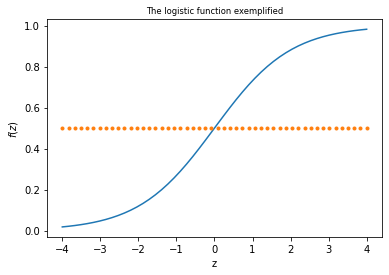

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# we implement the logistic function as a custom function
def logistic_fun(z):
    return 1/(1+np.exp(-z))


# create some data for plotting
z = np.linspace(-4, 4)

fz = logistic_fun(z)
plt.title("The logistic function exemplified", fontsize='small')
plt.plot(z, fz);
plt.plot(z, np.repeat(0.5, len(z)), ".");  #  just for fun, add a horizontal line to highlight 0.5
plt.ylabel("$f(z)$")
plt.xlabel("z")

It is a good exercise to check how changes in the above implementation change the plot. For example, you could add a constant multiplier and calculate $e^{(-\alpha z)} $ instead of $e^{(-z)}$, and check how the shape of the function changes with $\alpha$. 


## Maximum likelihood estimation & gradient descent
Estimating a logistic regression model involves minimizing the negative **log-likelihood** function. We discussed this in the lecture and experience suggests that some find this a little tough to digest, probably because of its level of formality. We will try to demystify the model by implementing it from scratch. For starters, however, recall that logistic regression models the probability of observing a certain state of our target variable $y$ by means of the logistic function. We assume a zero-one coded binary target variable $y \in {0, 1}$ and dependent on $\beta_0+\beta x$. Then, we can write the logit model as follows:

$$ p \left( y=1|x \right) = \frac{1}{1+e^{-z}}, \text{  and  }  p \left( y=0|x \right) = 1- p \left( y=1|x \right) $$

where $z$ is defined as a linear, additive function of the features: $z=\hat{\beta_0}+ \hat{\beta} x $. Assuming our data fulfills the IID assumption, we can write the log-likelihood function: 

$$ \mathcal{L} = \sum^{n}_{i=1} \left[ y_i \log \left(p \left( y=1|x \right) \right) + \left(1-y_i\right) \log \left(1-p \left( y=1|x \right) \right)\right]. $$

We need to now find the values of $ \hat{\beta} $ which minimize this function so it will be necesssary to take its derivative. We will calculate the derivative of the log likelihood with respect to $ \hat{\beta_i} $. Essentially, we will have to calculate this using the chain rule:

$$ \frac{\partial \mathcal{L}}{\partial \hat{\beta_i}} = \frac{\partial \mathcal{L}}{\partial p} \cdot \frac{\partial p}{\partial z} \cdot \frac{\partial z}{\partial \hat{\beta_i}} $$

Let's first calculate the three derivatives which we will need on the right hand side:

\begin{align*} 
\frac{\partial \mathcal{L}}{\partial p} &= \frac{y}{p} - \frac{1-y}{1-p} \\
\frac{\partial p}{\partial z} &= \frac{1}{1+e^{-z}} \cdot  \Bigg( 1 - \frac{1}{1+e^{-z}} \Bigg) = \Big( p \cdot  \big( 1 - p \big) \Big) \\
\frac{\partial z}{\partial \hat{\beta_i}} &= x_i
\end{align*}


Now we can multiply these three together to find the derivative of the log likelihood function with respect to $ \hat{\beta_i} $ :
 
\begin{align*}
 \frac{\partial \mathcal{L}}{\partial \hat{\beta_i}} &= \frac{\partial \mathcal{L}}{\partial p} \cdot \frac{\partial p}{\partial z} \cdot \frac{\partial z}{\partial \hat{\beta_i}} \\
 &= \Big( \frac{y}{p} - \frac{1-y}{1-p} \Big) \cdot \Big( p \cdot  \big( 1 - p \big) \Big) \cdot x_i \\
 &= (y(1-p) - p(1-y)) \cdot x_i \\ 
 &= (y - p) \cdot x_i
\end{align*}

And voilà! At the end, we have a much simpler formula to deal with:
$$ \frac{\partial \mathcal{L}}{\partial \hat{\beta_i}} = (y_i - p \left( y=1|x_i \right) ) \cdot x_i $$

In the most ideal world, we would be able to make an estimation $ \hat{\beta_i} $ for coefficients in our $ z $ function which would set this derivative to 0. However, this is not possible since the function is too complex. As such, we need to use another method. **Gradient descent** is the process of iteratively making changes to $ \hat{\beta_i} $ to assess which values lower the derivative value and, therefore, hopefully brings us closer to a minimum. Note that this may unfortunately not be the global minimum of the function but rather a local minimum. This is especially true if we have many coefficients or if any relationships are very complicated.

Additionally, if we change $ \hat{\beta_i} $ by too much in one iteration, we may end up overshooting a minimum which is counterproductive. In order to avoid this, we multiply the total difference by the learning rate $ \eta $ to dampen the update to $ \hat{\beta_i} $. If the learning rate is too low however, we may end up sabotaging ourselves as the function loses too much momentum in its updates. It is a good idea to experiment with a few different rates to see which one works best with your data.

Here is an equation which represents gradient descent:
$$ \hat{\beta_i} = \hat{\beta_{i-1}} - \eta \Delta( \hat{\beta_{i-1}}) \text{ if } || \hat{\beta_i} - \hat{\beta_{i-1}} || > \epsilon $$

For an alternative explanation, check out the [Wikipedia page for *gradient descent*](https://en.wikipedia.org/wiki/Gradient_descent). It will be crucial for you to understand this process, so take advantage of online resources to improve your understanding. There are also many ways to modify this process like stochastic gradient descent or adaptive learning rates which you will undoubtedly come across later in the field.

In [2]:
# Create synthetic data for classification using sklearn
from sklearn.datasets import make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_samples=500)

# Always useful to remind oneself of the dimensions of a data set
print("Shape of X {}".format(X.shape))  
print("Shape of y {}".format(y.shape))

Shape of X (500, 2)
Shape of y (500,)


## Logistic Regression from scratch

We can create a logistic regression function from scratch based on this [medium article](https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac). First, we need some data. To that end, we will re-use the approach for synthetic data creation from [Tutorial 3](https://github.com/Humboldt-WI/bads/blob/master/tutorials/3_nb_predictive_analytics.ipynb). The following code wraps up the Tutorial #3 codes in a custom function. Alternatively, we could have used the function `make_classification` from `sklearn`. We like our approach a little better but feel most free to change the data generation approach and try out the example using the `sklearn` data.

### Synthetic data generation

In [3]:
def toy_data(n=1000, mu1=[1,1], mu2=[4, 4], sig1=1, sig2=1):
    """ Customer function to generate linearly seperable toy data. The code has been discussed in more detail in Tutorial #3.
        
        The arguments represent, respectively, the size of the data, the mean vectors of the two Gaussians from which we
        sample class 1 and class 2 data points, and their standard deviations.
    """
    
    class1_x1 = np.random.normal(loc=mu1[0], scale=sig1, size=n)
    class1_x2 = np.random.normal(loc=mu1[1], scale=sig1, size=n)

    class2_x1 = np.random.normal(loc=mu2[0], scale=sig2, size=n)
    class2_x2 = np.random.normal(loc=mu2[1], scale=sig2, size=n)

    y1 = np.repeat(0, n)
    y2 = np.repeat(1, n)

    class1 = np.vstack((class1_x1, class1_x2)).T
    class2 = np.vstack((class2_x1, class2_x2)).T

    X = np.vstack((class1,class2))
    y = np.concatenate((y1,y2))
    
    return X, y

In [4]:
# Create and plot the data
X, y = toy_data()

# Always useful to remind oneself of the dimensions of a data set
print("Shape of X {}".format(X.shape))  
print("Shape of y {}".format(y.shape))

Shape of X (2000, 2)
Shape of y (2000,)


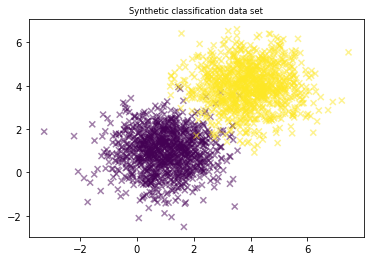

In [5]:
# Here is the code to plot the data
plt.title("Synthetic classification data set", fontsize='small')
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=.5, marker='x');

### Helper function for the logit model
We already defined the logistic function. We do it again to have all codes at a single space. This is only to aid readability. Note that data scientists very commonly refer to the logistic function as the **sigmoid**. The name relates to a class of learning machines called *artificial neural networks*, which are the backbone of deep learning. We use this term below, simply because it is sooo common and because we already used the logistic function for our above implementation.

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

We also need a loss function whose gradient we will determine which way to adjust parameters. Essentially, this is just our log-likelihood function. Easy enough to implement it in Python.

In [7]:
def loss(h, y):
    return (-y*np.log(h) - (1 - y)*np.log(1 - h))

Equipped with the previous functions, we are ready to implement logistic regression. More specifically, the below function takes care about **estimating a logistic regression model**. It determines and returns the weights (intercept and coefficients), which represent the logit model, as an 1D array. Remember that these weights are all we need to generate predictions for future data.

In [8]:
def estimate_logit_model(X, y, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
    
    # Add intercept to the model if needed
    if fit_intercept:
      intercept = np.ones((X.shape[0], 1))
      X = np.concatenate((intercept, X), axis=1)
        
    weights = np.zeros(X.shape[1]) # initialize weights
    
    for i in range(num_iter): # travels down the gradient as many times as there are iterations
        z = np.dot(X, weights)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        weights -= lr * gradient
            
    if(verbose == True and i % 10000 == 0): # checks loss at each iteration
        z = np.dot(X, weights)
        h = sigmoid(z)
        loss_val = loss(h, y)
        print(f'loss: {loss_val} \t')
    return weights

Lastly, we need some functionality for predicting probabilities for new data points. To replicate standard functionality of `sklean` in our custom logit model, we will supply two functions for prediction. Naturally, the logit model generates probabilistic predictions, which follows from using the sigmoid (aka logistic) function. Further, we supply a sklearn-like `predict()` function, which returns discrete class predictions using some **cut-off**, which we set to 0.5 by default. We can then compare this predicted value to the true labels and calculate the mean error or mean accuracy. 

In [9]:
def predict_prob(X, weights, fit_intercept=True):
    if fit_intercept:
        intercept = np.ones((X.shape[0], 1))
        X = np.concatenate((intercept, X), axis=1)
        return sigmoid(np.dot(X, weights))

In [10]:
def predict(X, weights, fit_intercept=True, threshold=0.5):
    predictions = predict_prob(X, weights, fit_intercept=fit_intercept) >= threshold
    predictions = np.where(predictions==False, 0, predictions)
    predictions = np.where(predictions==True, 1, predictions)
    return predictions

Now we can train our model on the data that we have generated to get the intercept (first number in the weights array) and coefficients (the subsequent numbers in the array). 

In [11]:
beta = estimate_logit_model(X, y)

In [12]:
print(beta)

[-10.59642991   2.2236904    2.17395292]


Ok, does maybe not look exciting but, believe it or not, these three numbers are our **logit model**. Really? Yes. All you need to calculate forecasts from a logistic regression models is the coefficients, one for each feature and one for the intercept. For our toy data, this translates into three numbers. 

All set, we are ready to put our model into production and estimate, for each case in our data, the probabilities of that case belonging to class 1. 

In [13]:
# This is how we produce class membership probabilities
results = predict_prob(X, beta, fit_intercept=True)
print(results[:5])

[3.86917537e-05 1.20429673e-05 6.63866627e-01 9.55794809e-02
 1.35224731e-06]


In [14]:
# And in this way, we can generate discrete class predictions
results = predict(X, beta, fit_intercept=True, threshold=0.5)
print(results[:5])

[0 0 1 0 0]


In [15]:
# Let's check the classification accuracy of our logit model
accuracy = y == results

mean_accuracy = accuracy.sum() / len(accuracy)

mean_accuracy

0.9855

To conclude this example, recall that we introduced logistic regression as a linear classifier in the lecture. To convince ourselves that logit really creates a linear decision boundary, we plot this boundary into our feature space using the intercept found in `beta[0]` and the two coefficients found in `beta[1]` and `beta[2]`. 

 In a two-dimensional space, with dimensions $(x_1, x_2)$, a hyperplane is defined by $\beta_1 x_1 + \beta_2 x_2 + \beta_0 = 0$. Rearranging terms, we obtain 
 $$ x_2 = - \frac{\beta_1}{\beta_2} x_1 - \frac{\beta_0}{\beta_2} $$
 
 Actually, this equation looks a little odd at first glance. We are used to think of $\mathbf{x}$ as data. So why is $x_2$ a function? Well, the equation simply gives as a blueprint of hot to plot the hyperplane in 2D. We generate some data for $x_1$. Next, using the estimated values for $\mathbf{\beta}$, we determine the corresponding value of $x_2$. This is only to facilitate drawing as follows: 

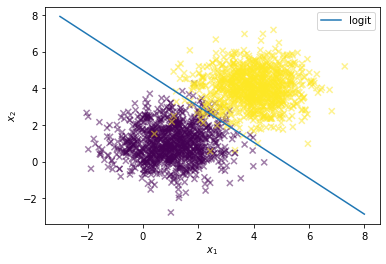

In [ ]:
# Generate data points
x_1 = np.linspace(-3, 8)  # we plot the hyperplane for this range of values

x_2 = - beta[1] / beta[2] * x_1 - beta[0] / beta[2]  # evaluate our above equation

# Ready to plot our hyperplane
fig = plt.figure()
plt.plot(x_1,x_2, label='logit');
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");
plt.legend(loc='best');
# Add the actual data to the plot (as before)
plt.scatter(X[:,0], X[:,1], c=y, alpha=.5, marker='x');

Looks good. Using the estimated parameters and drawing a line using these parameters, the plot confirms that we obtain a good separation of the two classes. And yet, we can create a better visualization in which we also evaluate the probability estimates of our model. So in case you missed the logistic function is the above example, no worries, we are getting there. To that end, we will compute the output (i.e., probability estimate) of our logit model over the entire feature space. More precisely, we decide on a value range for $x_1$ and $x_2$ and consider all possible input data points in that range. The resulting data is three dimensional and consists of tupels $\left( x_{i1}, x_{i2}, p_i \right)$, where $i$ is a data point index and $p_i$ is the probability forecast from the logit model for data point $\mathbf{x}_i$. Plotting in three dimensions in nontrivial. Below, we provide a working example for generating and plotting the data. The plot offers a maybe more accurate intuition on the inner workings of the logistic model and how it creates a linear classifier. Parts of the code will be hard to read. Feel free to just skip over them and look at the result (i.e., plot). If you want to understand what is going on, start with reading the documentation of the NumPy function `mgrid()`, look up demos for contour plots, and, of course, debug/alter the example in any way you like. 

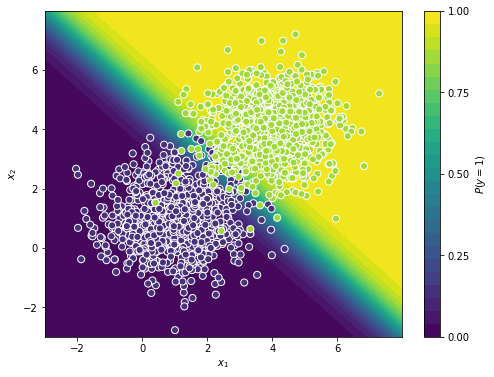

In [ ]:
# Graph to depict probability predictions of the logit model

xx, yy = np.mgrid[-3:8:.01, -3:8:.01]  # create input data for our logit model using mgrid
grid = np.c_[xx.ravel(), yy.ravel()]   # then transform the data into our standard format

# Calculate logit probability predictions
probs = predict_prob(grid, beta, fit_intercept=True)

# Reshape to facilitate plotting
probs = probs.reshape(xx.shape)

# Plot logit predictions
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25,  vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

# Plott the actual data points
# We alter the format of the scatter plot to ensure that data points are visible
ax.scatter(X[:,0], X[:,1], c=y, s=50, vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1);  
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");

## Libraries for logistic regression

Now that we know that estimating a logistic regression model using the maximum likelihood approach is not some sort of dark magic, we might feel more comfortable with using libraries that hide all the details. In fact, you have already seen one such library in action in [Tutorial 3](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/3_nb_predictive_analytics.ipynb). There, we used the `statsmodels` library to estimate a logit model. Let's revisit the corresponding codes. However, doing so for our toy data is pointless. It's time for a real-world data set and since we spent so much time on cleaning and preparing and understanding the HMEQ data in [Tutorial 4](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb), it would be a shame to not use it for demonstrating logistic regression on some real data. Remember that [Tutorial 4](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb) discusses that data set in detail, so simply go back to the previous tutorial is you need a refresher.

In [16]:
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
# Load data from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv' 
df = pd.read_csv(data_url, index_col="index")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's take a quick look at the data to re-familiarize ourselves with the classification task.

In [17]:
df.head(5)

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,,
0,True,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,True,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,True,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,True,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,False,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0


In [18]:
# Split into target and features
y = df.BAD.values.astype(int)
X = df.iloc[:,1:]

# We add a constant column to X. Think of this as the Python way to include an intercept in your model 
X = add_constant(X, prepend=True, has_constant='raise')
# Estimate logit model
logit_model = sm.Logit(y, X.astype(float), ) 
logit_model = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.394606
         Iterations 7


A nice feature of the `statsmodels` implementation is that you can easily produce a standard regression table. 

In [19]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5960
Model:                          Logit   Df Residuals:                     5941
Method:                           MLE   Df Model:                           18
Date:                Mon, 15 Mar 2021   Pseudo R-squ.:                  0.2103
Time:                        20:11:04   Log-Likelihood:                -2351.8
converged:                       True   LL-Null:                       -2978.2
Covariance Type:            nonrobust   LLR p-value:                5.480e-255
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1279      0.134     -8.389      0.000      -1.391      -0.864
LOAN                -0.1706      0.042     -4.018      0.000      -0.254      -0.087
MORTDUE             -0.1583      0.067     -2.366      0.018      -0.289      -0.027
VALUE                0.0619      0.070      0.885      0.376      -0.075       0.199
YOJ                 -0.0619      0.041     -1.510      0.131      -0.142       0.018
CLAGE               -0.4503      0.043    -10.520      0.000      -0.534      -0.366
NINQ                 0.2806      0.035      7.944      0.000       0.211       0.350
CLNO                -0.1448      0.042     -3.434      0.001      -0.227      -0.062
DEBTINC              0.4379      0.044     10.033      0.000       0.352       0.523
DEROGzero           -1.1282      0.097    -11.653      0.000      -1.318      -0.938
REASON_HomeImp       0.2465      0.086      2.878      0.004       0.079       0.414
REASON_IsMissing     0.3610      0.199      1.812      0.070      -0.030       0.751
JOB_Office          -0.6247      0.148     -4.219      0.000      -0.915      -0.335
JOB_Other           -0.0035      0.115     -0.031      0.976      -0.229       0.222
JOB_ProfExe          0.0853      0.133      0.643      0.520      -0.174       0.345
JOB_Sales            1.0241      0.261      3.925      0.000       0.513       1.536
JOB_Self             0.6369      0.212      3.005      0.003       0.221       1.052
DELINQcat_1          1.1760      0.104     11.334      0.000       0.973       1.379
DELINQcat_1+         2.1360      0.112     19.108      0.000       1.917       2.355
====================================================================================
"""

Spend a little time on inspecting the table. The pseudo $R^2$ statistic suggests that the model explains only a moderate amount of the variability of the target variable. However, we find from the *LLR test* that the model as a whole is highly significant. Further, most features come out as significant,  two dummy variables for the job categories *prof. executive* and *other* and the feature VALUE being an exception. Remember the result of the analysis of feature correlation in [Tutorial 4](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb)? The result for the VALUE feature is surely due to the high correlation of this feature with MORTDUE.    

In [20]:
np.corrcoef(df.MORTDUE, df.VALUE)

array([[1.        , 0.82513958],
       [0.82513958, 1.        ]])

Reestimating the logit model after removing the feature MORTDUE would be a good exercise. After the modification, VALUE should come out as significant.

We could easily continue our discussion of the regression table to draw more conclusions about our data. However, this is not the point the focal tutorial. Instead, let's look at another implementation of logistic regression. The famous `scikit-learn` library is the goto library for machine learning in Python. We will use it intensively throughout the course. It also supplies an implementation of logistic regression. Let's see how to use that implementation      

In [21]:
from sklearn.linear_model import LogisticRegression

sk_logit = LogisticRegression(penalty='none', fit_intercept=False)  # Recall that we already included a constant column in X. 
sk_logit.fit(X, y)                                                  # So we must set fit_intercept to False

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The sklearn implementation is geared toward predictive modeling. For example, there is no way to easily obtain fitting statistics or shed light on the significance of features. On the other hand, the class `LogisticRegression` supports many advanced features to maximize the predictive power of the logit model. The above output already hints at the many different parameters that you can configure. Have a look into the help if you'd like to learn more. We will cover important parameters like those associated with *regularization* in chapter 7 of BADS. One easy to appreciate advantage of `sklearn` over `statsmodels` when it comes to logistic regression is scalability. The sklearn implementation is faster and can cope with larger data sets.

Given the differences between our two logit models, the only way to compare them (for now) is by inspecting the estimated model coefficients.  

In [22]:
# Create a dataframe for the comparison
# Note that we also need some conversions to ensure that the two coefficient arrays are compatible
df_comparison = pd.DataFrame({"statsmodels" :logit_model.params.to_numpy(), "sklearn": sk_logit.coef_[0]})
df_comparison

,statsmodels,sklearn
0,-1.127897,-1.127687
1,-0.170567,-0.170544
2,-0.158264,-0.158239
3,0.061895,0.061884
4,-0.061869,-0.061875
5,-0.450325,-0.450316
6,0.280649,0.280644
7,-0.144770,-0.144765
8,0.437894,0.437879
9,-1.128196,-1.128196


**Conclusion:** the two implementations of the logit model deliver similar results. That is nice but maybe not too exciting. The main take-away is that, when it comes to logistic regression, ask yourself whether you want to use the model for an explanatory or predictive purpose. Use the implementation within `statsmodels` in the former and `sklearn` in the latter case. 

# Decision Trees

Decision trees are useful and powerful algorithms for classifying and regressing data. It works on recursive partitioning which will be shown algorithmically in this notebook. Though most of the the time, Sci-Kit Learn can be used to implement this machine learning method simply, it is useful to take a look at the inner workings of these algorithms. The following parts will first introduce a decision tree from scratch, before demonstrating its coverage in `sklearn`. 

## Decision Tree From Scratch Using HMEQ Data

Firstly, we will go through a decision tree made from scratch. The following code is based on the material originally created by Sebastian Mantey for the Iris Dataset whose GitHub is here: https://github.com/SebastianMantey/Decision-Tree-from-Scratch. You can also search his video on YouTube. The code has been adapted to this course's format and fit to HMEQ Dataset.

Just in case you made changes to the data by running the above code, we first reload the data to a fixed and clear-defined starting point for our tree classifier. Recall that we defined the variable `data_url` above.

In [23]:
df = pd.read_csv(data_url, header = 0, index_col = 0) # import file with header and index as first row and column respectively

df.head() #inspect data to make sure it looks correct

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,,
0,True,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,True,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,True,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,True,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,False,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0


In [24]:
X = df.drop(['BAD'], axis=1) #code the variables in the most standard way for your usage
y = df[['BAD']]

In [25]:
print(type(X), type(y), X.shape, y.shape) # double check that types and dimensions are correct before proceeding

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> (5960, 18) (5960, 1)


### Helper Functions for the Tree

Decision trees work by recursively partitioning data which means:

Many potential ways to split the data are calculated (eg. we are going to go through all unique values of each column and finding the midpoint between sequential values). For each potential split, we evaluate whether the target variable has more homogeneity in each leaf. This is done by calculating 'impurity' of the parent node and comparing it with the sum of the impurity of the child nodes. There are three major impurity functions: entropy, gini and misclassification. We will be using entropy in our example. The split which yields the lowest impurity is chosen and the process is repeated for the new nodes (this is recursion). 

The method of choosing the split which yields the lowest impurity is called the greedy search method. The following functions will help the decision tree implement greedy search tactics on the data. The algorithm stops either when purity in each node is reached or when it has reached a maximum depth (max amount of recursions we allow) specified in our function.

Many functions for the tree are not found in Python packages and it is cleaner to write them out first then put them together in our main algorithm. Each function below does a specific action which will be used in our final tree function at the end.

In [26]:
def check_purity(y):
    
    'checks if a leaf node is perfectly pure, in other words, if the leaf node contains only one class'
    
    unique_classes = np.unique(y) #count number of classes in section of data

    if len(unique_classes) == 1: #check if the node is pure
        return True
    else:
        return False

In [27]:
def classify_data(y):
    
    'classifies data according to the majority class of each leaf'
    
    unique_classes, counts_unique_classes = np.unique(y, return_counts=True)
    #returns classes and no. of obs per class

    index = counts_unique_classes.argmax() #index of class with most obs
    classification = unique_classes[index] #class chosen for classification which is class with most obs
    
    prob = len(y[y == 1]) / len(y) #returns proportion of class 1 in the leaf (prob of class 1)

    return [classification, prob]

In [28]:
def get_potential_splits(X):
    
    'first, takes every unique value of every feature in the feature space, then finds the midpoint between each value'
    
    potential_splits = {}
    _, n_columns = X.shape #don't need rows, we choose the column to split on
    # only need second value of .shape which is columns
    
    for column_index in range(n_columns):
        potential_splits[column_index] = [] 
        values = X[:, column_index] 
        unique_values = np.unique(values) #get all unique values in each column

        for index in range(len(unique_values)): #all unique feature values
            if index != 0: #skip first value, we need the difference between next values
                current_value = unique_values[index]
                previous_value = unique_values[index - 1] #find a value and the next smallest value
                potential_split = (current_value + previous_value) / 2 #find difference between the two as a potential split
                
                #consider all values which lie between two values as a potential split
                
                potential_splits[column_index].append(potential_split)
    
    return potential_splits

In [29]:
def split_data(X, y, split_column, split_value):
    
    'splits data based on specific value, will yield both a split for the features X and target y'
    
    split_column_values = X[:, split_column]

    X_below = X[split_column_values <= split_value] #partitions data according to split values from previous functions
    X_above = X[split_column_values >  split_value]
    
    y_below = y[split_column_values <= split_value]
    y_above = y[split_column_values >  split_value]
    
    return X_below, X_above, y_below, y_above

In [30]:
def calculate_entropy(y):
    
    'calculates entropy for each partition of data'
    
    _, counts = np.unique(y, return_counts=True) #we only need the counts of each class, _ is a placeholder

    probabilities = counts / counts.sum() #probability of each class
    entropy = sum(probabilities * -np.log2(probabilities)) #could replace with Gini impurity or misclassification
     
    return entropy

In [31]:
def calculate_overall_entropy(y_below, y_above): 
    
    'calculates the total entropy after each split'
       
    n = len(y_below) + len(y_above)
    p_data_below = len(y_below) / n
    p_data_above = len(y_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(y_below)
                      + p_data_above * calculate_entropy(y_above))
    
    return overall_entropy

In [32]:
def determine_best_split(X, y, potential_splits):
    
    'selects which split lowered entropy the most'
    
    overall_entropy = 9999 #set arbitrarily high, the function will loop over and replace this with lower impurity values
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            X_below, X_above, y_below, y_above = split_data(X, y, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(y_below, y_above)
            
            #goes through each potential split and only updates if it lowers entropy

            if current_overall_entropy <= overall_entropy: 
                overall_entropy = current_overall_entropy #updates only if lower entropy split found, in the ned this is greedy search
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

### The Main Algorithm

The tree will now implement the helper functions and display the decision which yielded the best split if printed. Since the growing the tree can take a little bit of time, the argument `verbose` also exists which gives you status updates on the algorithm's progress. This is common for quite a few functions in the programming world.

In [33]:
def decision_tree_algorithm(X, y, counter=0, min_samples=2, max_depth=5, verbose=False): 
    
    # data preparation
    if counter == 0:  # counter tells us how deep the tree is, this is before the tree is initiated
        global COLUMN_HEADERS
        COLUMN_HEADERS = X.columns
        X = X.values  # change all to NumPy array for faster calculations
        y = y.values
        if verbose:
          print("Data preparation complete, tree initiated")
          print("Creating first branch until first leaf, branches will then be calculated sequentially")
    else:
        data = X  # if we have started the tree, X should already be a NumPy array from the code above 
    # base cases
    if (check_purity(y)) or (len(X) < min_samples) or (counter == max_depth):
        if verbose:
          if (check_purity(y)):
              print("Classes pure, new leaf node created")
          elif (len(X) < min_samples):
              print("Min samples reached, new leaf node created")
          else:
              print("Max depth reached, new leaf node created")
        classification, prob = classify_data(y)
        return classification, prob
    
    # recursive part
    else:    

        # helper functions 
        if verbose:
            print("Calculating splits at depth of", counter)
        potential_splits = get_potential_splits(X)  # check for all possible splits

        if bool([feature_splits for feature_splits in potential_splits.values() if feature_splits != []]): # Checks that potential_splits is not just a blank dictionary (occurs when random feature subspace has no variation in observations)        
            best_split_column, best_split_value = determine_best_split(X, y, potential_splits)  # select best split based on entropy
            X_below, X_above, y_below, y_above = split_data(X, y, best_split_column, best_split_value)  # execute best split
         
            # Code to explain decisions made by tree to users
            feature_name = COLUMN_HEADERS[best_split_column]
            question = "{} <= {}".format(feature_name, best_split_value)  # initiate explanation of split
            sub_tree = {question: []}
        
            # Pull answers from tree
            if verbose:
                print("Processing first split at depth", counter)
            yes_answer = decision_tree_algorithm(X_below, y_below, counter + 1, min_samples, max_depth, verbose)
            if verbose:
                print("Processing second split at depth", counter)
            no_answer = decision_tree_algorithm(X_above, y_above, counter + 1, min_samples, max_depth, verbose)
        
            # Ensure explanation actually shows useful information
            if yes_answer == no_answer:  # if decisions are the same, only display one
                sub_tree = yes_answer
            else:
                sub_tree[question].append(yes_answer)
                sub_tree[question].append(no_answer)

            if verbose:
             if (counter == 0):
                print("Tree Complete")

        else: # if potential_splits is empty due to lack of feature variation, just classify the data at this point
            classification = classify_data(y)
            return classification
        
        return sub_tree

### Grow First Tree

Test the tree and display the decisions with a shallow depth.

In [34]:
tree = decision_tree_algorithm(X, y, max_depth=2, verbose=True)

Data preparation complete, tree initiated
Creating first branch until first leaf, branches will then be calculated sequentially
Calculating splits at depth of 0
Processing first split at depth 0
Calculating splits at depth of 1
Processing first split at depth 1
Max depth reached, new leaf node created
Processing second split at depth 1
Max depth reached, new leaf node created
Processing second split at depth 0
Calculating splits at depth of 1
Processing first split at depth 1
Max depth reached, new leaf node created
Processing second split at depth 1
Max depth reached, new leaf node created
Tree Complete


#### Structure of the First Tree

In [36]:
from pprint import pprint  # library for prettier print output

pprint(tree)

{'DEBTINC <= 0.13253751764464605': [{'DELINQcat_1+ <= 0.5': [(False,
                                                              0.04424379232505643),
                                                             (False,
                                                              0.2777777777777778)]},
                                    {'DEBTINC <= 0.137471043429223': [(True,
                                                                       0.6182246661429693),
                                                                      (False,
                                                                       0.11466325660699062)]}]}


In [37]:
tree.values()

dict_values([[{'DELINQcat_1+ <= 0.5': [(False, 0.04424379232505643), (False, 0.2777777777777778)]}, {'DEBTINC <= 0.137471043429223': [(True, 0.6182246661429693), (False, 0.11466325660699062)]}]])

The first node in the tree asks the question:

DEBTINC <= 0.13253751764464605

If this is true, the tree will predict BAD as false.

If this is false, the tree will ask a second question:

DEBTINC <= 0.137471043429223

If true, the tree will predict BAD is true. If false, the tree will predict BAD is false.

#### Classification Example from First Tree

Let's take an example and see how the tree classifies it.

In [38]:
example = df.iloc[2] #take a random observation
example

BAD                      True
LOAN                 -1.78905
MORTDUE              -1.65455
VALUE                -1.83928
YOJ                 -0.668103
CLAGE               -0.368769
NINQ               -0.0650545
CLNO                  -1.1893
DEBTINC              0.137456
DEROGzero                True
REASON_HomeImp              1
REASON_IsMissing            0
JOB_Office                  0
JOB_Other                   1
JOB_ProfExe                 0
JOB_Sales                   0
JOB_Self                    0
DELINQcat_1                 0
DELINQcat_1+                0
Name: 2, dtype: object

To put this example down our tree, we implement a function `classify_example()`. Eventually, we would like our tree to facilitate prediction in a similar way as `sklearn` models. Therefore, we also implement two *wrapper* functions `predict()` and `predict_proba()`; as we did before for our custom logit model. These functions kind of 'wrap up' the function `classify_example()` - hence the name wrapper function - and call it for every instance in a data set.

In [39]:
def classify_example(example, tree):
    question = list(tree.keys())[0] #checks what is the next data split
    feature_name, comparison_operator, value = question.split() #splits question into elements

    # ask question
    if example[feature_name] <= float(value): # checks key element for split
        answer = tree[question][0] # selects yes answer
    else:
        answer = tree[question][1] # selects no answer

    # base case
    if not isinstance(answer, dict): # if answer is not a dictionary, we have reached a decision
        return answer # display prediction
    
    # recursive part
    else:
        residual_tree = answer # continue if another dictionary is reached
        return classify_example(example, residual_tree)

# function for predicting class of observation
def predict(tree, data):
  pred = data.apply(classify_example, axis=1, args=(tree,))
  return [int(row[0]) for row in pred]

# function for predicting probability of observation being class 1 
def predict_prob(tree, data):
  pred = data.apply(classify_example, axis=1, args=(tree,))
  return [row[1] for row in pred]

Ok, finally, here is the classification result for the above instance:

In [40]:
classify_example(example, tree)

(True, 0.6182246661429693)

In [41]:
y.iloc[2]

BAD    True
Name: 2, dtype: bool

The classification for this one instance is correct. It will be more interesting though to examine how well the tree classifiers a set of - or all - instances in our data. This is where our `predict()` functions come into play. 

#### Predictions and Accuracy from First Tree

In [42]:
predictions = predict(tree, X)  # obtain discrete class predictions (i.e., majority class in the respective leaf nodes)

predictions[:5]

[1, 1, 1, 1, 1]

In [43]:
predictions_prob = predict_prob(tree, X) #probability of being class 1

predictions_prob[:5]

[0.6182246661429693,
 0.6182246661429693,
 0.6182246661429693,
 0.6182246661429693,
 0.6182246661429693]

In [44]:
error = np.mean(np.vstack(predictions) == np.array(y))

error

0.851006711409396

The tree is able to classify a good proportion of the test set well even with only a depth of 2.

### Higher Depth in Tree

Test the tree and display the decisions with a higher depth to see if accuracy changed. Be warned, the computations might take a few minutes to complete. After growing the tree, we will proceed as before with calculating predictions and examining their accuracy.

In [45]:
tree_deep = decision_tree_algorithm(X, y, max_depth=5, verbose=True)

Data preparation complete, tree initiated
Creating first branch until first leaf, branches will then be calculated sequentially
Calculating splits at depth of 0
Processing first split at depth 0
Calculating splits at depth of 1
Processing first split at depth 1
Calculating splits at depth of 2
Processing first split at depth 2
Calculating splits at depth of 3
Processing first split at depth 3
Calculating splits at depth of 4
Processing first split at depth 4
Max depth reached, new leaf node created
Processing second split at depth 4
Max depth reached, new leaf node created
Processing second split at depth 3
Calculating splits at depth of 4
Processing first split at depth 4
Classes pure, new leaf node created
Processing second split at depth 4
Max depth reached, new leaf node created
Processing second split at depth 2
Calculating splits at depth of 3
Processing first split at depth 3
Calculating splits at depth of 4
Processing first split at depth 4
Classes pure, new leaf node created
P

In [46]:
pprint(tree_deep)

{'DEBTINC <= 0.13253751764464605': [{'DELINQcat_1+ <= 0.5': [{'YOJ <= -0.45235911313134003': [{'MORTDUE <= -0.9625627627614091': [{'LOAN <= -0.5406409454191005': [(False,
                                                                                                                                                                    0.46875),
                                                                                                                                                                   (False,
                                                                                                                                                                    0.07407407407407407)]},
                                                                                                                                  {'CLAGE <= -1.6018838077330106': [(True,
                                                                                                                             

In [47]:
predictions_deep = predict(tree_deep, X)

predictions_deep[:5]

[1, 1, 1, 1, 1]

In [48]:
predictions_prob_deep = predict_prob(tree_deep, X)

predictions_prob_deep[:5]

[0.61003861003861,
 0.8564814814814815,
 0.61003861003861,
 0.61003861003861,
 0.61003861003861]

In [49]:
error_deep = np.mean(np.vstack(predictions_deep) == np.array(y))

error_deep

0.8897651006711409

The performance of the tree is even better with this depth. However, as we continue to increase depth, there will come a point where the accuracy decreases as the tree internalizes noise from the data. This is called overfitting and weakens the tree's ability to classify unseen observations. Thus, the tree can be deepened only until the test set accuracy begins decreasing.

## Decision Trees with Sci-Kit Learn

As mentioned, the package Ski-Kit Learn has prebuilt functions which avoid coding most algorithms by scratch. Now armed with the knowledge of the inner workings of the decision tree, it should be easier to understand what this algorithm is trying to achieve.

In [50]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=2, max_depth=2) #keep tree at a low depth

dt_shallow = clf.fit(X, y)

In [51]:
pred_dt_shallow = dt_shallow.predict(X)

In [52]:
pred_dt_shallow[0:5]

array([ True,  True,  True,  True,  True])

In [53]:
classify_correct_shallow = pred_dt_shallow == y.iloc[:,0]
accuracy_shallow = classify_correct_shallow.mean()


accuracy_shallow

0.851006711409396

[Text(167.4, 181.2, 'X[7] <= 0.133\nentropy = 0.721\nsamples = 5960\nvalue = [4771, 1189]'),
 Text(83.7, 108.72, 'X[17] <= 0.5\nentropy = 0.315\nsamples = 2341\nvalue = [2208, 133]'),
 Text(41.85, 36.23999999999998, 'entropy = 0.261\nsamples = 2215\nvalue = [2117, 98]'),
 Text(125.55000000000001, 36.23999999999998, 'entropy = 0.852\nsamples = 126\nvalue = [91, 35]'),
 Text(251.10000000000002, 108.72, 'X[7] <= 0.137\nentropy = 0.871\nsamples = 3619\nvalue = [2563, 1056]'),
 Text(209.25, 36.23999999999998, 'entropy = 0.959\nsamples = 1273\nvalue = [486, 787]'),
 Text(292.95, 36.23999999999998, 'entropy = 0.514\nsamples = 2346\nvalue = [2077, 269]')]

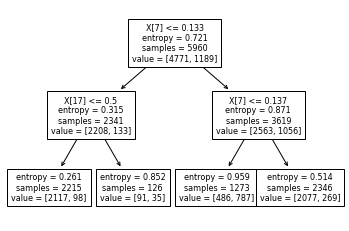

In [54]:
tree.plot_tree(dt_shallow, fontsize=8)

### SK Learn Tree with No Limit on Depth

If we remove the maximum depth parameter, the algorithm will go as far as it can until all nodes are pure.

In [55]:
clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2)

dt_deep = clf.fit(X, y)

pred_dt_deep = dt_deep.predict(X)

In [56]:
pred_dt_deep[0:5]

array([ True,  True,  True,  True, False])

In [57]:
classify_correct_deep = pred_dt_deep == y.iloc[:,0]
accuracy_deep = classify_correct_deep.mean()

accuracy_deep

1.0

While this seems great at first glance, what is the problem here? What does this mean for new data that we encounter whose idiosyncracies may be slightly different than the data we used to train the model?

# Conclusion

There you have it! We have taken many strides to get to this point to complete your first regression and classification problems! There are many ways to refine the technique, we'll keep learning more in the next lessons and tutorials. Try some of these on your own and see if you can get some of your own models up and running.



## Overview Table

NumPy code which was used here:


| Goal | Possible Code |
| --- | --- |
| Generate n evenly spaced numbers between min and max | `np.linspace(min, max, num=n)` |
| Generate n sized array drawn from specified random normal | `np.random.normal(loc=mean, scale=var, size=n)` |
| Arrange array vertically | `np.vstack(array)` |
| Concatenate arrays | `np.concatenate(array1, array2)` |
| Create a matrix or array of 1s in the shape of 2 rows and 2 cols | `np.ones((2,2))` |
| Dot product of two arrays | `np.dot(array1, array2)`|
| If else with NumPy array | `np.where(condition, value_if_true, value_if_false)` |
| If array element < 1:  multiply element by two, else: set element to 0 | `np.where(array<1, array*2, 0)` |
| Create correlation matrix of two arrays or `pandas` Series | `np.corrcoef(array, array)` |

`statsmodels.api` code for logistic regression:

| Goal | Possible Code |
| --- | --- |
| Add constant to features | `add_constant(X, prepend=True, has_constant='raise')` |
| Generate logistic regression | `sm.Logit(y.astype(int), X.astype(float), ) ` |
| Fit logistic regression | `model_name.fit()` |
| Get summary of regression | `fitted_model.summary()` |

*Note that you must save the fitted model under a new name with `statsmodels.api`. It was overwritten in the same name in this tutorial.

`sklearn` code implemented here:

| Goal | Possible Code |
| --- | --- |
| Generate decision tree classifier | `tree.DecisionTreeClassifier()` |
| Generate logistic regression | `LogisticRegression(penalty='none', fit_intercept=False) ` |
| Fit model to X and y | `model_name.fit(X, y)`|
| Predict based on X | `model_name.predict(X)` |